/Users/forest/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


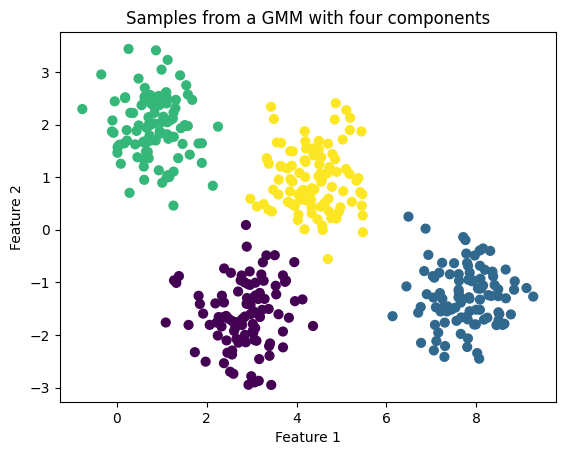

In [1]:
import numpy as np
import sklearn
from sklearn import mixture
from matplotlib import pyplot as plt
import scipy.stats as sp
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from sklearn.datasets import make_blobs
from matplotlib.ticker import FixedLocator, LinearLocator, FormatStrFormatter
from matplotlib import cm
import pandas as pd
from sklearn.metrics import silhouette_score
import scipy
from sklearn.cluster import KMeans
import pymc3 as pm
from theano import tensor as tt
import theano
eps = 1e-16


# Generate some data
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] 


kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Samples from a GMM with four components')
plt.show()

In [2]:
# Peform the kernel density estimate
x = X[:,0]
y = X[:,1]
xmin = np.min(x)
xmax = np.max(x)
ymin = np.min(y)
ymax = np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = sp.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

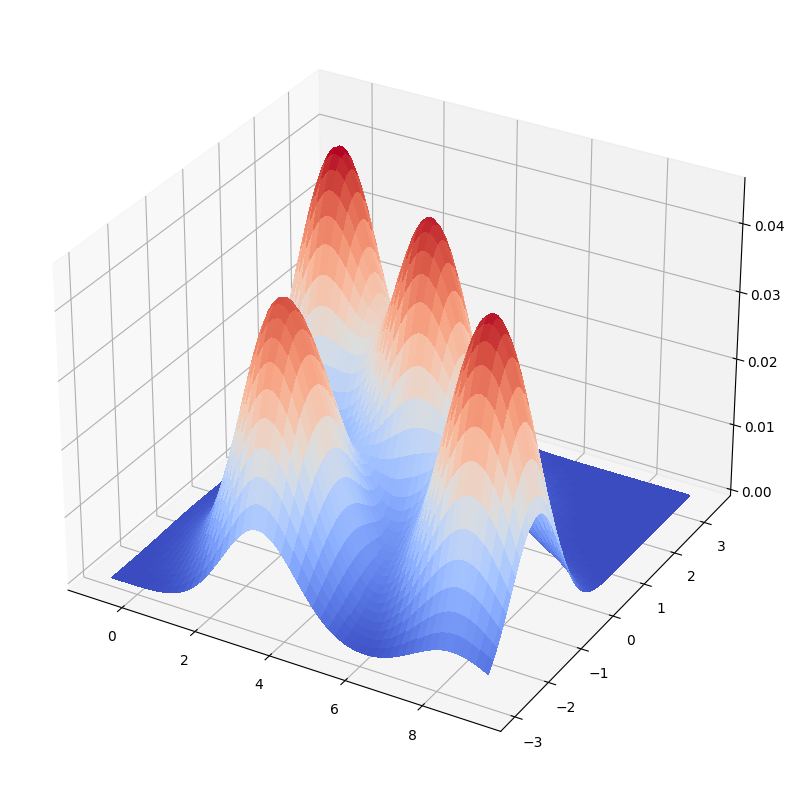

In [4]:
# Plot the surface.
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(projection='3d')

surf = ax.plot_surface(xx, yy, f, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

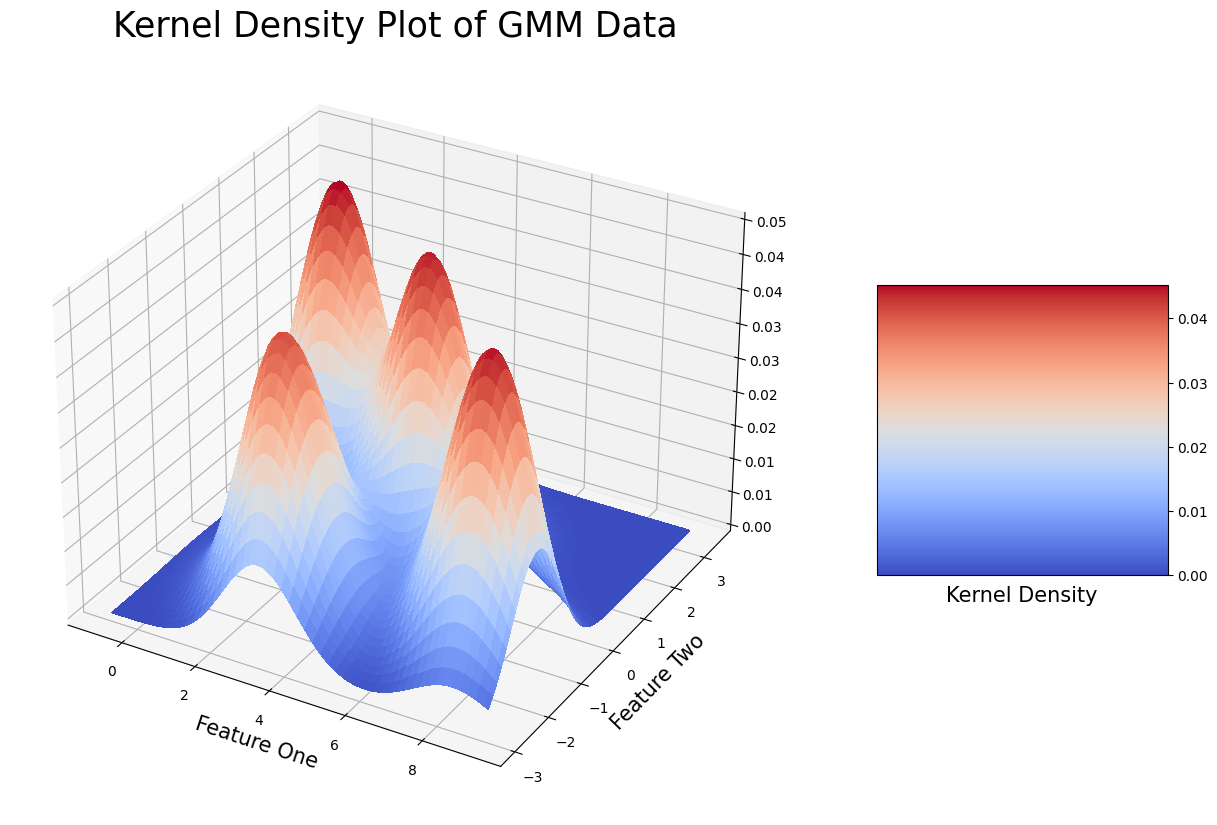

In [5]:
# Plot the surface.
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(projection='3d')

surf = ax.plot_surface(xx, yy, f, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
mate = fig.colorbar(surf, shrink=0.5, aspect=1)
mate.ax.set_xlabel('Kernel Density',fontsize=15)
plt.xlabel('Feature One',fontsize=15)
plt.ylabel('Feature Two',fontsize=15)
plt.title('Kernel Density Plot of GMM Data',fontsize=25)

plt.show()

In [6]:
def genCov(dim):
    a = 2
    A = np.matrix([np.random.randn(dim) + np.random.randn(1)*a for i in range(dim)])
    A = A*np.transpose(A)
    D_half = np.diag(np.diag(A)**(-0.5))
    C = D_half*A*D_half
    sigma = np.diag(np.random.uniform(low=0,high=5,size=(dim)))
    return np.dot(np.dot(sigma,C),sigma)

In [7]:
#Number of features in our GMM
dim=20
N=10000

#Number of clusters
n_clusters = np.random.choice(range(5,10))

#Sample random mixing proportions
mix_prop = np.random.dirichlet([1 for x in range(n_clusters)])

#Initialise random covariance matrices
covs = [genCov(dim) for x in range(n_clusters)]

#Initialise random mean vectors
means = [np.random.uniform(low=1,high=20,size=dim) for x in range(n_clusters)]

#Sample cluster assignments
gAssign = np.random.multinomial(10000, mix_prop)
assignments = np.repeat(range(n_clusters),gAssign)

#Generate Data
mix = np.vstack([sp.multivariate_normal.rvs(mean=m,cov=c,size=g) for m,c,g in zip(means,covs,gAssign)])

In [8]:
# Peform the kernel density estimate
x = mix[:,0]
y = mix[:,1]
xmin = np.min(x)
xmax = np.max(x)
ymin = np.min(y)
ymax = np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = sp.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

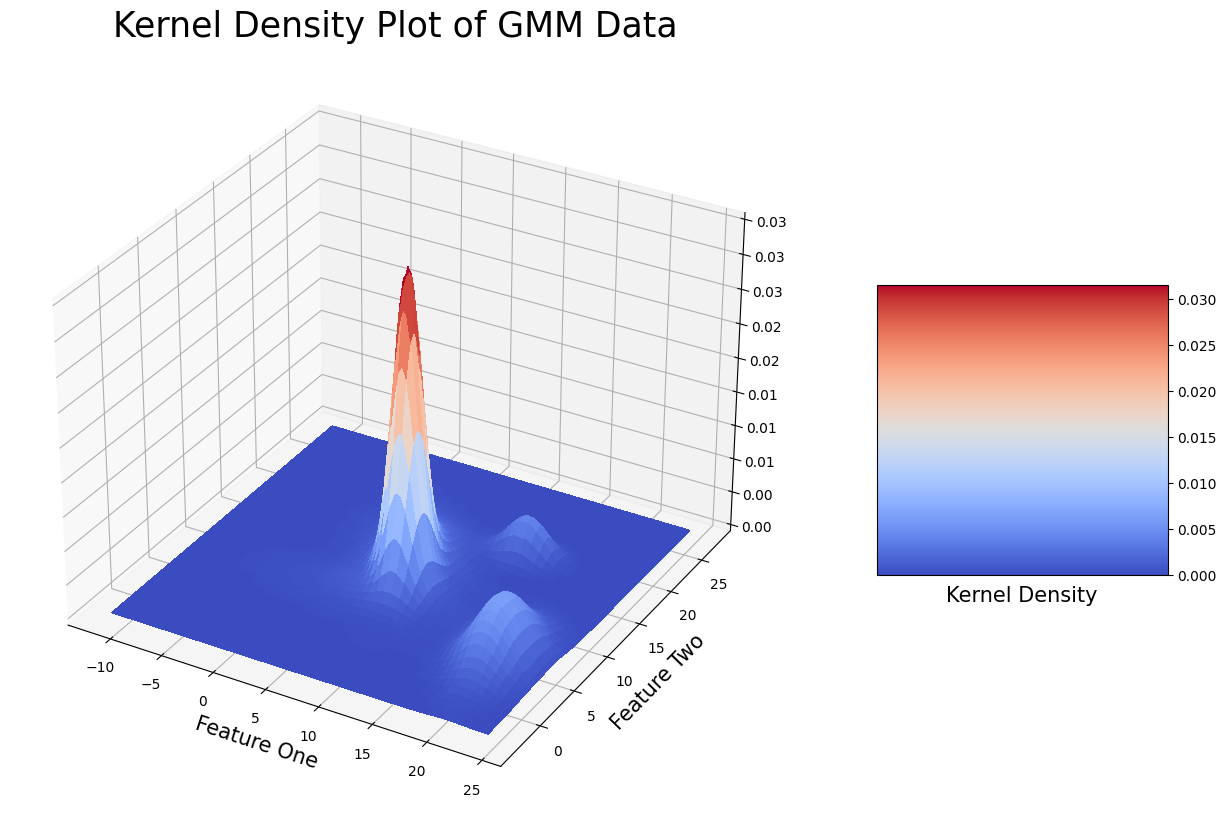

In [10]:
# Plot the surface.
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(projection='3d')

surf = ax.plot_surface(xx, yy, f, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
mate = fig.colorbar(surf, shrink=0.5, aspect=1)
mate.ax.set_xlabel('Kernel Density',fontsize=15)
plt.xlabel('Feature One',fontsize=15)
plt.ylabel('Feature Two',fontsize=15)
plt.title('Kernel Density Plot of GMM Data',fontsize=25)

plt.show()

In [11]:
DPGMM = mixture.BayesianGaussianMixture(n_components=15, 
                                                max_iter=100000000,
                                                n_init=10,
                                                tol=1e-5, 
                                                init_params='kmeans', 
                                                weight_concentration_prior_type='dirichlet_process',
                                                weight_concentration_prior=1/10)
DPGMM.fit(mix)

BayesianGaussianMixture(max_iter=100000000, n_components=15, n_init=10,
                        tol=1e-05, weight_concentration_prior=0.1)

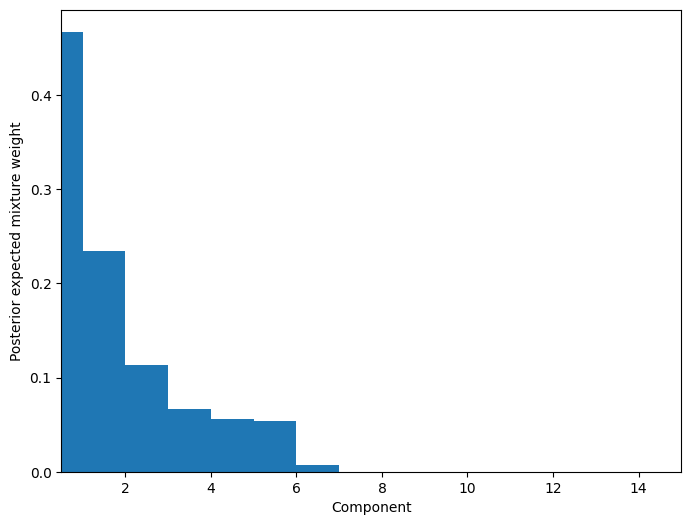

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(15) + 1

ax.bar(plot_w - 0.5, np.sort(DPGMM.weights_)[::-1], width=1., lw=0);

ax.set_xlim(0.5, 15);
ax.set_xlabel('Component');

ax.set_ylabel('Posterior expected mixture weight');

In [25]:
DPGMM.means_.shape

(15, 20)

In [27]:
DPGMM.covariances_.shape

(15, 20, 20)

In [13]:
n_to_select = 8
w = (-DPGMM.weights_).argsort()[:n_to_select]
mat = []
for ind2 in w:
    row = []
    for ind1 in range(len(means)):
        p1 = sp.multivariate_normal.pdf(mix,mean=means[ind1],cov=covs[ind1]) + eps
        p2 = sp.multivariate_normal.pdf(mix,mean=DPGMM.means_[ind2],cov=DPGMM.covariances_[ind2]) + eps
        row.append(sp.entropy(p1 + eps,p2 + eps))
    mat.append(row)
print(pd.DataFrame(mat))

           0          1          2          3          4          5          6
0  13.081698  13.008183  13.276672  12.655932  15.373689   0.057557  11.888855
1  18.081912  18.008397  18.276886  17.656146  20.373903  16.271474   0.202054
2  20.753192  20.679678  20.948165   0.194085  23.045182  18.942872  19.560348
3   0.300552  15.574626  15.843113  15.222373  17.940130  13.837928  14.455296
4  13.713875   0.224843  13.908848  13.288109  16.005866  11.903687  12.521032
5  18.436672  18.363158   0.494686  18.010905  20.728662  16.626456  17.243828
6  10.247708  10.174195  10.442681   9.821941   0.722306   8.437570   9.054864
7  14.855218  14.781706  15.050191  14.429452  17.147208  13.007023  13.662375


In [14]:
w

array([ 5,  2,  0,  4,  3, 11, 14,  9])

In [15]:
mat = []
for ind2 in w:
    p1 = sp.multivariate_normal.pdf(mix,mean=DPGMM.means_[ind2],cov=DPGMM.covariances_[ind2]) + eps
    mat.append(p1)
clusts = pd.DataFrame(mat).T.idxmax(axis=1)

In [30]:
mix.shape

(10000, 20)

In [31]:
X.shape

(10000, 2)

In [32]:
assignments

array([0, 0, 0, ..., 6, 6, 6])

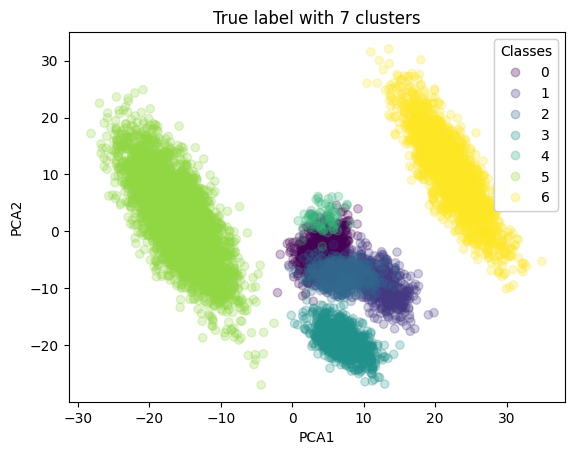

In [16]:
from sklearn.decomposition import PCA
pca= PCA(n_components=2)
X = pca.fit_transform(mix)
fig, ax = plt.subplots()

scatter = ax.scatter(X[:, 0], X[:, 1], c=assignments, cmap=plt.cm.viridis, alpha=.25);
plt.title("True label with %s clusters" %len(np.unique(assignments)));
plt.xlabel('PCA1')
plt.ylabel('PCA2')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)

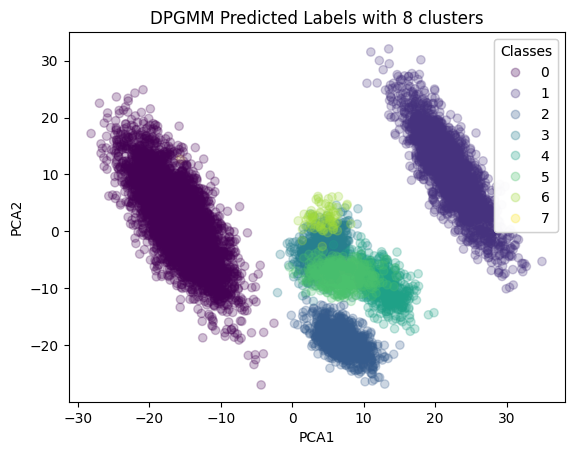

In [17]:
fig, ax = plt.subplots()


scatter = ax.scatter(X[:, 0], X[:, 1], c=clusts, cmap=plt.cm.viridis, alpha=.25);
plt.title("DPGMM Predicted Labels with %s clusters" %len(np.unique(clusts)));
plt.xlabel('PCA1')
plt.ylabel('PCA2')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)

/Users/forest/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/forest/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/forest/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/forest/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to su

Text(0.5, 0, 'Average Silhouette Score')

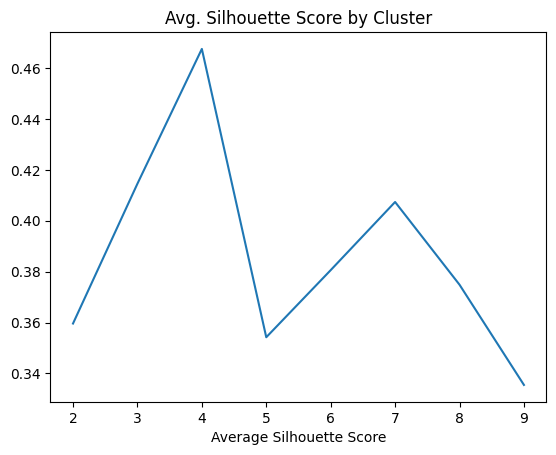

In [18]:
range_n_clusters = [2, 3, 4, 5, 6,7,8,9]
silscore = []
for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(mix)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(mix, cluster_labels)
    silscore.append(silhouette_avg)
pd.Series(silscore,index=range_n_clusters).plot()
plt.title('Avg. Silhouette Score by Cluster')
plt.xlabel('N. Clusters')
plt.xlabel('Average Silhouette Score')

In [21]:
n_clust = 6
clusterer = KMeans(n_clusters=n_clust, random_state=10)
cluster_labels = clusterer.fit_predict(mix)
mat = []
for c in range(n_clust):
    row = []
    m_sub = mix[cluster_labels == c].mean(axis=0)
    m_cov = np.cov(mix[cluster_labels == c].transpose())
    for ind1 in range(len(means)):
        p1 = sp.multivariate_normal.pdf(mix,mean=means[ind1],cov=covs[ind1]) + eps
        p2 = sp.multivariate_normal.pdf(mix,mean=m_sub,cov=m_cov) + eps
        row.append(sp.entropy(p1,p2))
    mat.append(row)
print(pd.DataFrame(mat))

/Users/forest/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


           0          1          2          3          4          5          6
0   3.699392   4.033690   4.808330   4.187591   6.905042   2.803693   3.420514
1  14.445271  14.371765  14.640242  14.019503  16.737260   0.665216  13.252426
2  23.268274  23.194768  23.463246  22.842506  25.560263  21.458398   0.011889
3  24.518317  24.444812  24.713289   0.024653  26.810306  22.708540  23.325472
4  31.243324  31.169819   0.055003  30.817556  33.535313  29.433583  30.050479
5  14.281131  14.207626  14.476103  13.855364  16.573121   0.814162  13.088286


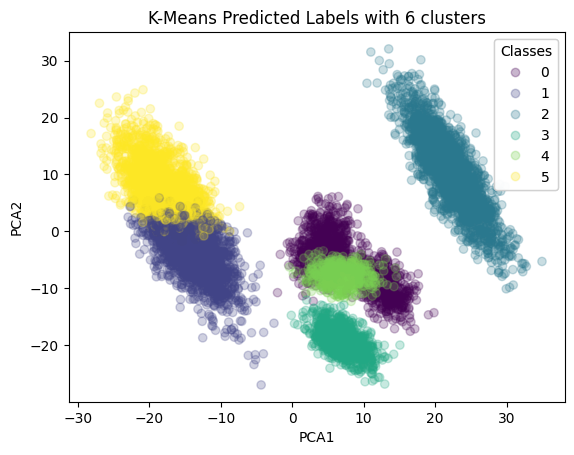

In [22]:
fig, ax = plt.subplots()
scatter = ax.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap=plt.cm.viridis, alpha=.25);
plt.title("K-Means Predicted Labels with %s clusters" %len(np.unique(cluster_labels)));
plt.xlabel('PCA1')
plt.ylabel('PCA2')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)